## 4. Gradient Bandit Algorithms
The sample-average and upper-confidence-bound methods estimated the action values and used those estimates to select actions. Here, we learn a numerical preference $H_t(a)$ for each action a. The score has can not be interpreted in terms of reward, we only care about the relative preference of one action over another - the larger the preference, the more often that action is taken.

The probability that an action is taken is determined by a soft-max distribution (or Boltzmann distribution):
$$Pr\{A_t = a\} = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} = \pi_t(a)$$

$\pi_t(a)$ is the probability of taking action a at time t.
Initially, all preferences are the same ($H_1(a) = 0, \forall a$) so that all actions have an equal probability of being selected. On each step, after selection an action $A_t$ and receiving reward $R_t$, the preferences are updated by:

$$H_{t+1}(A_t) = H_t(A_t) + \alpha(R_t - \bar R_t)(1 - \pi_t(A_t)) \text { and}$$
$$H_{t+1}(a) = H_t(a) - \alpha(R_t - \bar R_t)\pi_t(a) \space \forall a \neq A_t$$


$\alpha$ is the step size and $\bar R_t$ is the average of all the rewards received up through and including time t. $\bar R_t$ serves as a baseline with which the reward is compared. If the reward is higher than the baseline $(R_t - \bar R_t > 0)$, then the probability of taking $A_t$ in the future is increased, and if the reward is below the baseline $(R_t - \bar R_t < 0)$, then the probability is decreased. The non-selected actions move in the opposite direction.

We will now evaluate the performance of the gradient bandit algorithm. As before, we set k = 10 but we set the true expected rewards according to a normal distribution with a mean of +4 and unit variance. We test combinations where $\alpha = 0.1$ and $\alpha = 0.4$ as well as with and without a baseline $(\bar R_t = 0)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def pi_t(Ht):
    """
    Calculates the probabilities of taking actions
    :param Ht: The numerical preference for each action
    """
    expos = np.exp(Ht)
    denom = np.sum(expos)
    return expos / denom

In [3]:
def get_reward(true_values, a):
    """
    Returns the reward for selecting action a.
    Reward is selected around true_values[a] with unit variance (as in problem description)
    :param true_values: list of expected reward for each action
    :param a: index of action to return reward for
    """
    reward = np.random.normal(true_values[a], size=1)[0]
    return reward

In [4]:
def k_armed_bandit(k, alpha, iterations, use_baseline):
    """
    Performs a single run of the k-armed bandit experiment
    :param k: the number of arms
    :param alpha: The step-size
    :param iterations: number of steps in a single run
    """
    # Randomly assign true values of reward for each action with mean 0 and variance 1
    true_values = np.random.normal(4.0, size=k)
    
    # Numerical preference for each action
    Ht = np.zeros(k)
    
    # Store the rewards received for this experiment
    rewards = []
    
    # Track how often the optimal action was selected
    optimal = []
    
    if use_baseline:
        baseline = 0.0
    
    for n in range(1, iterations + 1):         
        # Pick the action with the probability
        a = np.random.choice(np.flatnonzero(Ht == Ht.max()))
        reward = get_reward(true_values, a)
        
        # Obtain probability of selecting each action
        pt = pi_t(Ht)        
        
        if use_baseline:
            # Incremental average computation
            baseline += (1.0 / n) * (reward - baseline)
            alpha_diff = alpha * (reward - baseline)
        else:
            alpha_diff = alpha * reward
            
        Ht[a] += alpha_diff * (1 - pt[a])
        for i in range(k):
            if i == a:
                continue
            Ht[i] -= alpha_diff * pt[a]            
        
        rewards.append(reward)
        optimal.append(1 if a == true_values.argmax() else 0)
    
    return rewards, optimal

In [5]:
def experiment(k, alpha, iters, epochs, use_baseline=True):
    """
    Runs the k-armed bandit experiment
    :param k: the number of arms
    :param alpha: the step-size
    :param iters: the number of steps in a single run
    :param epochs: the number of runs to execute
    :param use_baseline: if true, use the average reward as a baseline
    """
    rewards = []
    optimal = []
    
    for i in range(epochs):
        r, o = k_armed_bandit(k, alpha, iters, use_baseline)
        rewards.append(r)
        optimal.append(o)
        
    if use_baseline:
        print('Experiment with alpha = {} with baseline'.format(alpha))
    else:
        print('Experiment with alpha = {} without baselie'.format(alpha))
    
    # Compute the mean reward for each iteration
    r_means = np.mean(rewards, axis=0)
    o_means = np.mean(optimal, axis=0)
    
    return r_means, o_means

In [6]:
k = 10
steps = 1000
runs = 2000

In [7]:
r_exp1, o_exp1 = experiment(k, 0.1, steps, runs, False)
r_exp2, o_exp2 = experiment(k, 0.1, steps, runs, True)
r_exp3, o_exp3 = experiment(k, 0.4, steps, runs, False)
r_exp4, o_exp4 = experiment(k, 0.4, steps, runs, True)

Experiment with alpha = 0.1 without baselie
Experiment with alpha = 0.1 with baseline
Experiment with alpha = 0.4 without baselie
Experiment with alpha = 0.4 with baseline


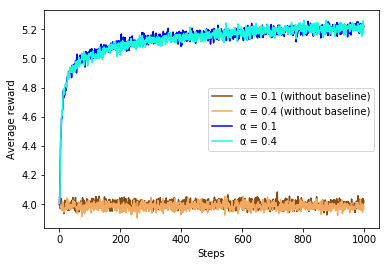

In [8]:
x_axis = range(steps)
plt.plot(x_axis, r_exp1, c='#854b15', label='\u03b1 = 0.1 (without baseline)')
plt.plot(x_axis, r_exp3, c='#f5a85f', label='\u03b1 = 0.4 (without baseline)')
plt.plot(x_axis, r_exp2, c='blue', label='\u03b1 = 0.1')
plt.plot(x_axis, r_exp4, c='#17fcde', label='\u03b1 = 0.4')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

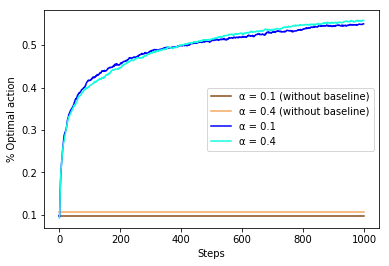

In [9]:
x_axis = range(steps)
plt.plot(x_axis, o_exp1, c='#854b15', label='\u03b1 = 0.1 (without baseline)')
plt.plot(x_axis, o_exp3, c='#f5a85f', label='\u03b1 = 0.4 (without baseline)')
plt.plot(x_axis, o_exp2, c='blue', label='\u03b1 = 0.1')
plt.plot(x_axis, o_exp4, c='#17fcde', label='\u03b1 = 0.4')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()